In [2]:
import io
import os
import glob
import cbor2
import math
import numpy as np
import struct
import matplotlib.pyplot as plt
from scipy.signal import freqz, sosfreqz, sosfilt, butter, find_peaks, peak_prominences

In [3]:
data = {key: [] for key in ('right1', 'right2', 'left1', 'left2')}
for filename in sorted(glob.glob('2024-01-28/*.cbor')):
    with open(filename, 'rb') as infile:
        while True:
            try:
                datum = cbor2.load(infile)
            except cbor2.CBORDecodeEOF:
                break
            bio = io.BytesIO(bytes(datum['stream']))
            while True:
                try:
                    item = cbor2.load(bio)
                except cbor2.CBORDecodeEOF:
                    break
                item = cbor2.loads(item['data'])
                if item['type'] != 'piezo-dual':
                    continue
                for key in data.keys():
                    data[key].extend([0xFFFFFF & x for x in struct.unpack('<500I', item[key])])

In [4]:
data = {key: np.array(value) for key, value in data.items()}

(<Axes: >, <Axes: xlabel='Frequency', ylabel='Magnitude (energy)'>)

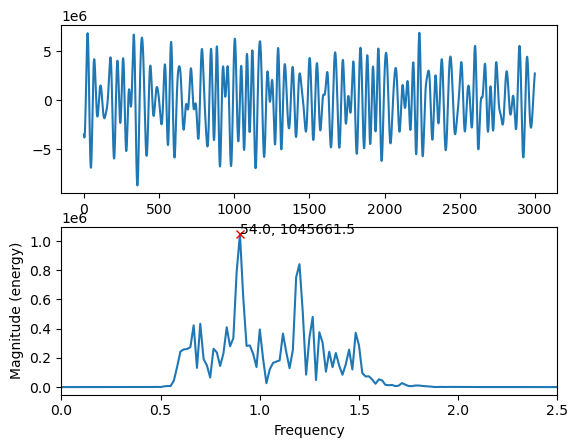

In [13]:
def butter_bandpass(lowcut, highcut, fs, order=5, **kwargs):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band', **kwargs)

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    return sosfilt(butter_bandpass(lowcut, highcut, fs, order=order, output='sos'), data)

origfreq = 500
newfreq = 50
skip = int(origfreq // newfreq)
newfreq = origfreq/skip

def heartpass(series):
    interestrange = (40/60, 90/60)
    
    return butter_bandpass_filter(series[::skip], interestrange[0], interestrange[1], newfreq, order=9)

def show_slice(series, offset_secs, len_secs, ax=None):
    slice = series[int(offset_secs*newfreq):int((offset_secs+len_secs)*newfreq)]
    if ax is None:
        ax = plt.subplot(2, 1, 1), plt.subplot(2, 1, 2)

    plt1, plt2 = ax

    plt1.plot(slice)
    pow, freq, unused = plt2.magnitude_spectrum(slice, Fs=newfreq)
    
    powfreq = list(map(tuple, zip(freq, pow)))
    peak_indices = find_peaks(pow, height=np.max(pow)*0.8, distance=20)[0]
    prominences = peak_prominences(pow, peak_indices)[0]
    peaks = [powfreq[index] for index in peak_indices]
    plt2.plot([freq for freq, pow in peaks], [pow for freq, pow in peaks], "xr")
    plt2.axis(xmax=2.5, xmin=0)
    
    for (freq, pow), prominence in zip(peaks, prominences):
        plt2.annotate('{:3.1f}, {:3.1f}'.format(freq*60, prominence), (freq, pow))
    
    return ax

series = heartpass(data['right1'])
show_slice(series, 3600*3, 60)

In [14]:
%matplotlib
from matplotlib.animation import FuncAnimation

filtered_data = {key: heartpass(value) for key, value in data.items()}
filtered_data['leftdelta'] = filtered_data['left1'] - filtered_data['left2']
filtered_data['rightdelta'] = filtered_data['right1'] - filtered_data['right2']

plt.close()
fig, ax = plt.subplots(2, len(filtered_data.keys()), sharey='row')
fig.suptitle('Heart rate from piezo')

offset = 3600*3
window = 60
increment = 1
def initanim():
    for index, (key, value) in enumerate(sorted(filtered_data.items())):
        show_slice(value, offset, window, (ax[0][index], ax[1][index]))
    return ax

def updateanim(frame):
    for index, (key, value) in enumerate(sorted(filtered_data.items())):
        ax[0][index].cla()
        ax[0][index].set_title(key)
        ax[1][index].cla()
        show_slice(value, offset+frame*increment, window, (ax[0][index], ax[1][index]))
    return ax

ani = FuncAnimation(fig, updateanim, init_func=initanim, frames=3600, blit=False, interval=1000.0/30.0)
plt.show()

Using matplotlib backend: <object object at 0x7fe20c15d760>
